In [1]:
import numpy as np
import torch
import pandas as pd
import logging
import json
import xgboost as xgb
from Models.xgboostHannes import *
from Models.rfHannes import *
from Models.helperfunctions import *
from Models.ETE import *
from Models.TSnocontext import *

from base_agent import Agent
from sklearn.ensemble import RandomForestRegressor

/Users/niekvandergaag/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%pip install contextualbandits


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [126]:
X, y = parse_data("Bibtex_data.txt")
print(X.shape)
print(y.shape)
print(X[0])
print(y[0])

(7395, 1836)
(7395, 159)
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
print(context_size, contexts.shape, rewards.shape)
print(X_new.shape, y_new.shape)
print(X.shape, y.shape)

1836 (3416, 1836) (3416, 10)
(3416, 1836) (3416, 10)
(7395, 1836) (7395, 159)


In [12]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from contextualbandits.online import PartitionedTS, ExploreFirst, _BasePolicy, _BasePolicyWithExploit, BootstrappedTS
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import _BasePolicy
from contextualbandits._cy_utils import _choice_over_rows, topN_byrow, topN_byrow_softmax

X, y = parse_data("Bibtex_data.txt")
print(X.shape)
print(y.shape)
nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
contexts = X # these are the features
rewards = y # these are the labels
n_arms = nchoices


# Define the environment constructor
env_constructor = lambda: SimpleBanditEnv(contexts, rewards, n_arms)

xgb_agent = BernoulliXGBoostTSAgent(
    env_constructor=env_constructor,  
    context_size=X.shape[1], 
    n_estimators=100,
    max_depth=6,
    exploration_variance=1.0,
    initial_random_selections=10,
)
rf_agent = BernoulliRandomForestTSAgent(
    env_constructor=env_constructor,  
    context_size=X.shape[1], 
    n_estimators=100,
    max_depth=6,
    exploration_variance=1.0,
    initial_random_selections=10
)
partitioned_ts_agent = PartitionedTS(
    nchoices=nchoices,  # Explicitly pass nchoices here
    beta_prior=beta_prior_ts,  # Custom beta prior for Thompson Sampling
    random_state=2222,  # Set a random state for reproducibility
    njobs=-1,  # Use all CPU cores for parallel processing
    max_depth=5,  # Optional: You can pass additional decision tree parameters here
    min_samples_leaf=8 # Optional: Minimum samples per leaf
)
ete_agent = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             explore_rounds=1500, beta_prior=None, random_state = 8888)

bootstrapped_ts_agent = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = 2222)


models = [bootstrapped_ts_agent, xgb_agent, rf_agent, partitioned_ts_agent, ete_agent]

(7395, 1836)
(7395, 159)
Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


In [ ]:
# These lists will keep track of the rewards obtained by each policy
rewards_bootstrapped, rewards_part_ts, rewards_ete, rewards_rf, rewards_xgb = [list() for i in range(len(models))]

lst_rewards = [rewards_bootstrapped, rewards_part_ts, rewards_ete, rewards_rf, rewards_xgb]

# batch size - algorithms will be refit after N rounds
batch_size = 50
# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    if isinstance(model, (BernoulliXGBoostTSAgent, BernoulliRandomForestTSAgent)):
        # For custom agents, simulate the first batch fitting by iterating through the batch
        for t in range(batch_size):
            context = first_batch[t].reshape(1, -1)
            action = action_chosen[t]  # Now 'action' is an integer
            reward = rewards_received[t]
            model.update_observation({action: context}, action, reward)
    else:
        # For PartitionedTS and ExploreFirst, use the fit method
        model.fit(X=first_batch, a=action_chosen, r=rewards_received)

lst_a_bootstrapped, lst_a_partTS, lst_a_ete, lst_a_rf, lst_a_xgb = [action_chosen.copy() for i in range(len(models))]
lst_actions = [lst_a_bootstrapped, lst_a_partTS, lst_a_ete, lst_a_rf, lst_a_xgb]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)

    if isinstance(model, (BernoulliXGBoostTSAgent, BernoulliRandomForestTSAgent)):
        actions_this_batch = []
        for t in range(batch_st, batch_end):
            context = X_global[t].reshape(1, -1)
            action_namespace = model.pick_action({arm: context for arm in range(nchoices)})  # Returns a SimpleNamespace
            action = int(action_namespace.label)  # Extract the integer action label
            actions_this_batch.append(action)
        actions_this_batch = np.array(actions_this_batch)
    else:
        actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')

    # Ensure the actions_this_batch are integers before indexing
    actions_this_batch = actions_this_batch.astype(int)

    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    if isinstance(model, (BernoulliXGBoostTSAgent, BernoulliRandomForestTSAgent)):
        for t in range(batch_st, batch_end):
            context = X_global[t].reshape(1, -1)
            action = actions_this_batch[t - batch_st]
            reward = y_global[t, action]
            model.update_observation({action: context}, action, reward)
    else:
        model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])

    return new_actions_hist



# Now running all the simulations
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)


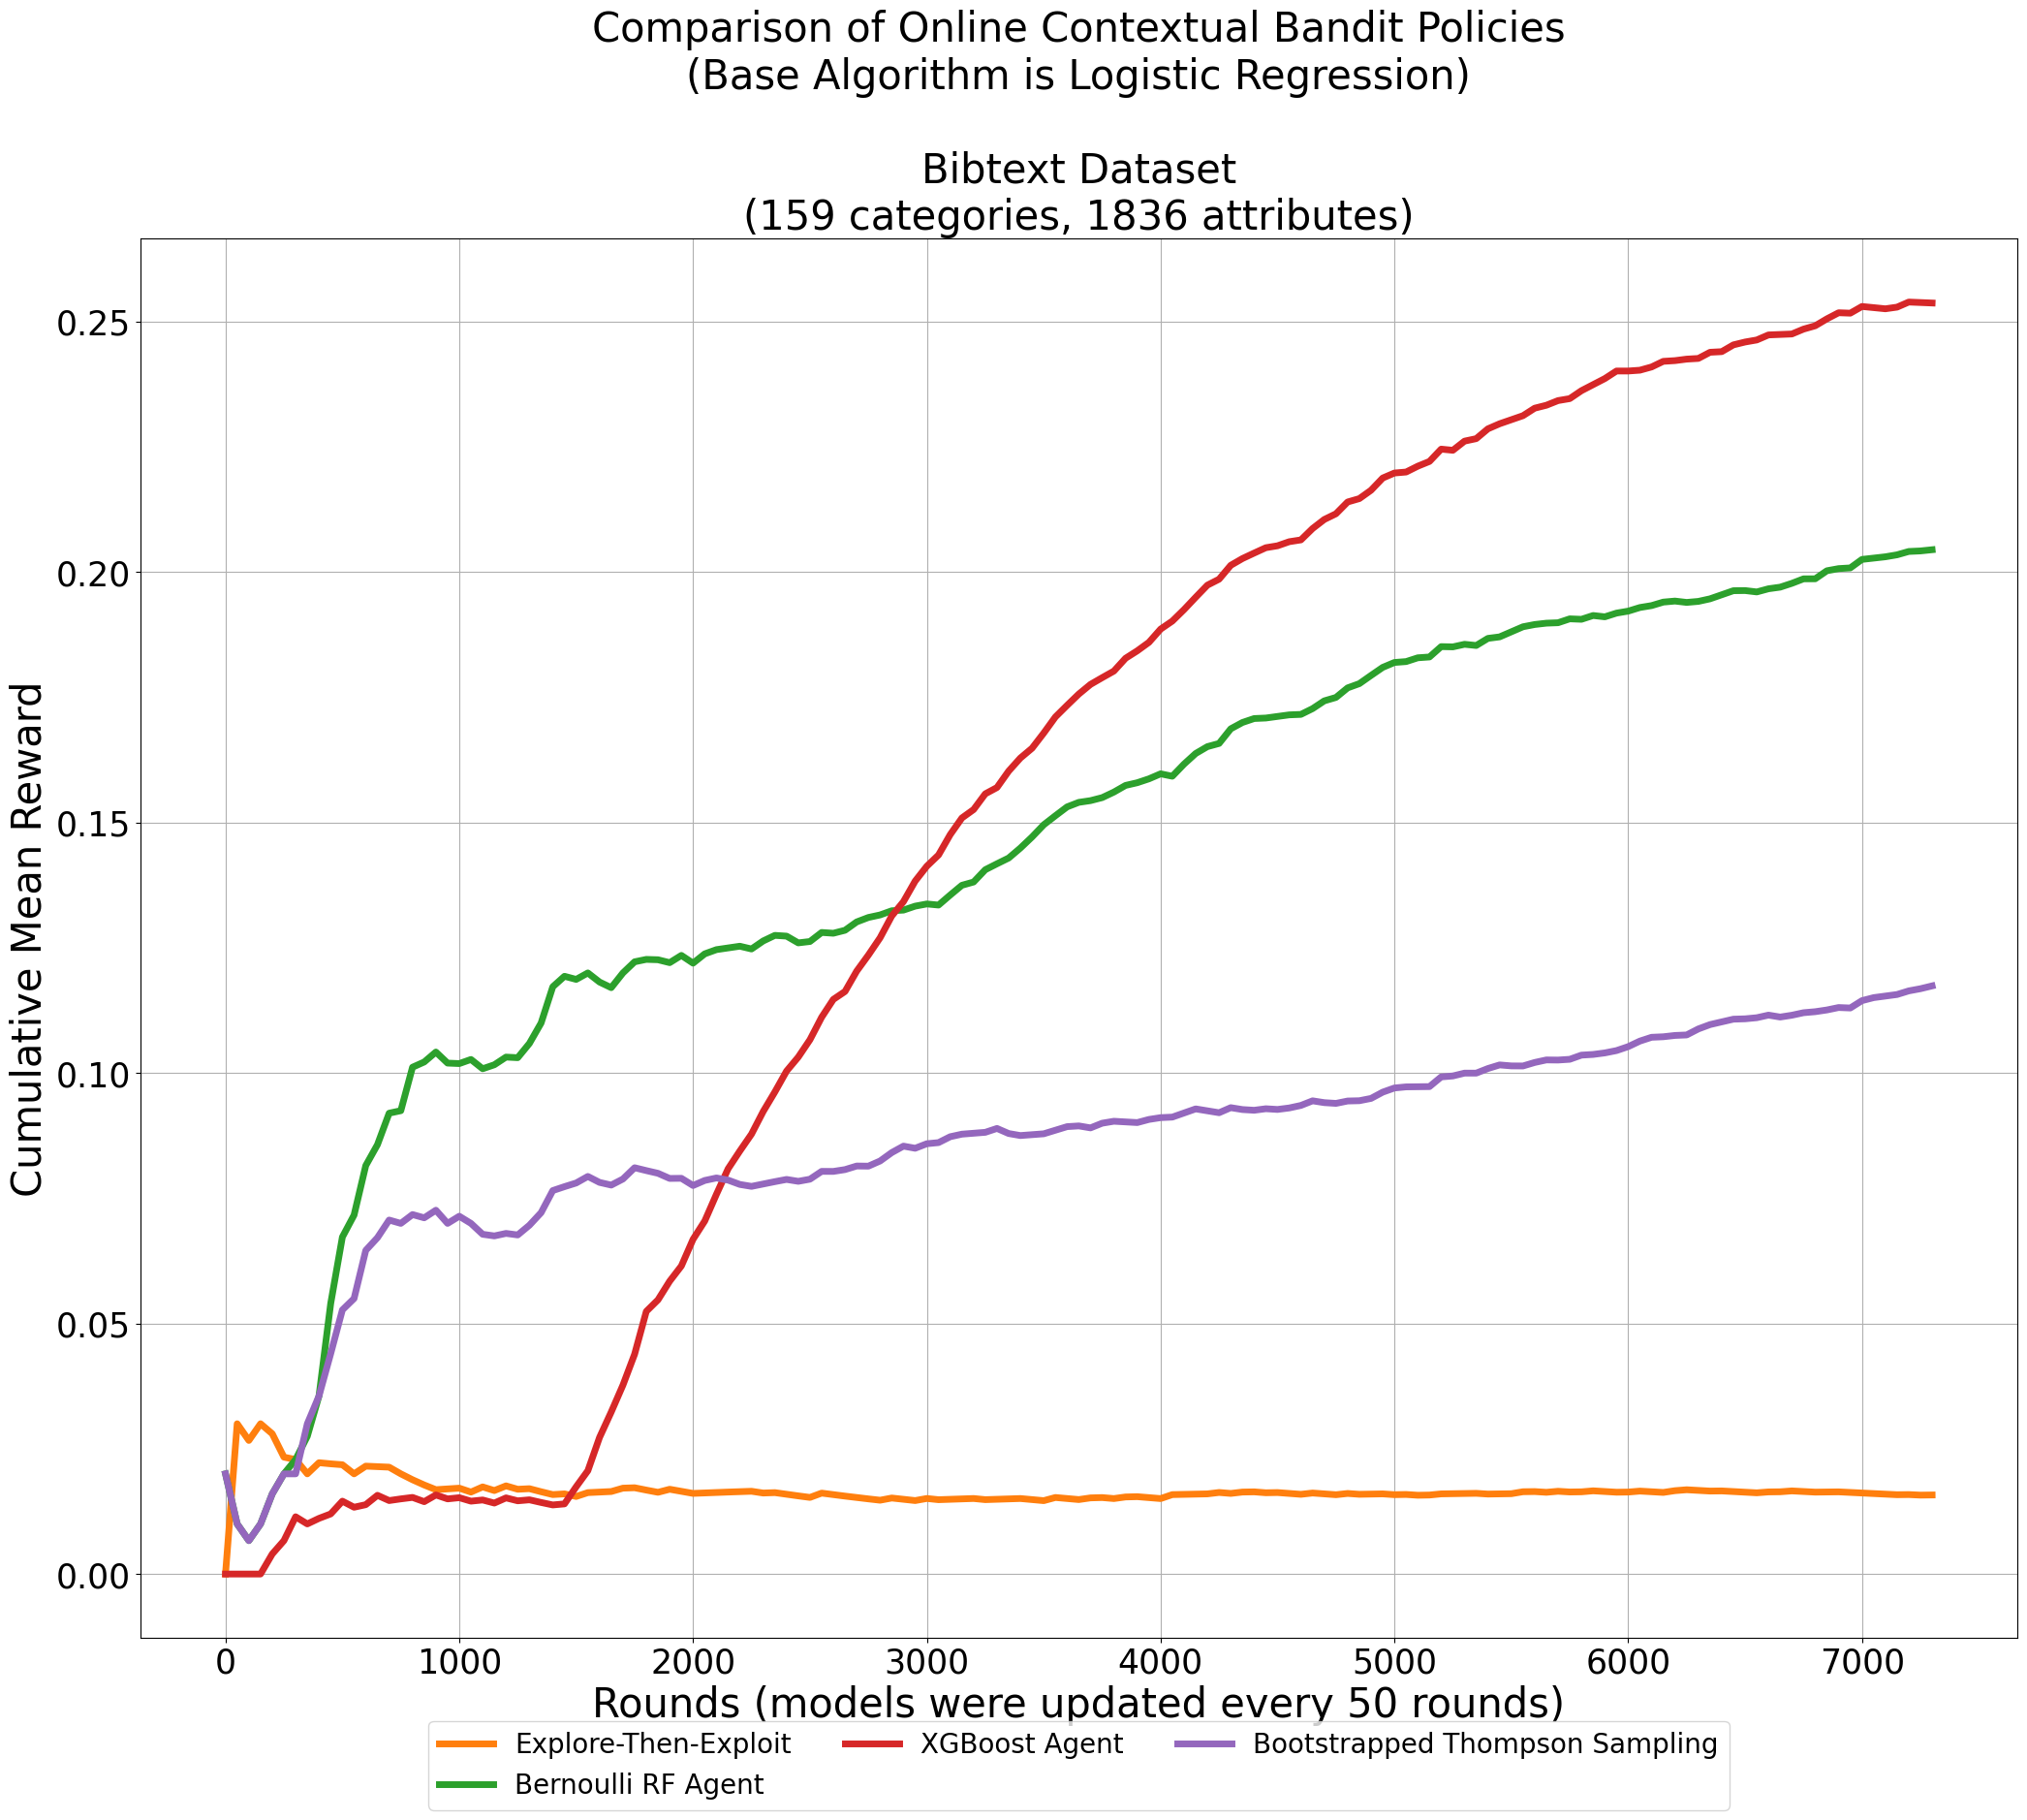

In [14]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
#plt.plot(get_mean_reward(rewards_part_ts), label="Partitioned Thompson Sampling",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ete), label="Explore-Then-Exploit",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_rf), label="Bernoulli RF Agent",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_xgb), label="XGBoost Agent",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_bootstrapped), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[8])

# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

(7395, 1836)
(7395, 159)
Initial Parameters:
nchoices: 159, beta_prior: ((0.2734899508482878, 4), 2)
Initial Model Fitting Done.
Actions chosen: [ 37 140  72 137 133  79 144 129  71 134  25  20 101 146 139 156 157 142
  50  68  96  86 141 137   7  63  61  22  57   1 128  60   8 141 115 121
  30  71 131 149  49  57   3  24  43  76  26  52  80 109]
Rewards received: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Initial rewards: 0
Model Updated after Batch 100
Batch 50-100: Actions Predicted: [107 120  12  46 138  89 125  59 117 128  98  92   4 112  71  30 123 154
 132  98  90 113 127 139 104 113  41  82  53  85  52  63  29 117 114  82
  51 127  68  41 120  45 103  48   4 103  98  61 153  10]
Corresponding Contexts: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Actual Rewards: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

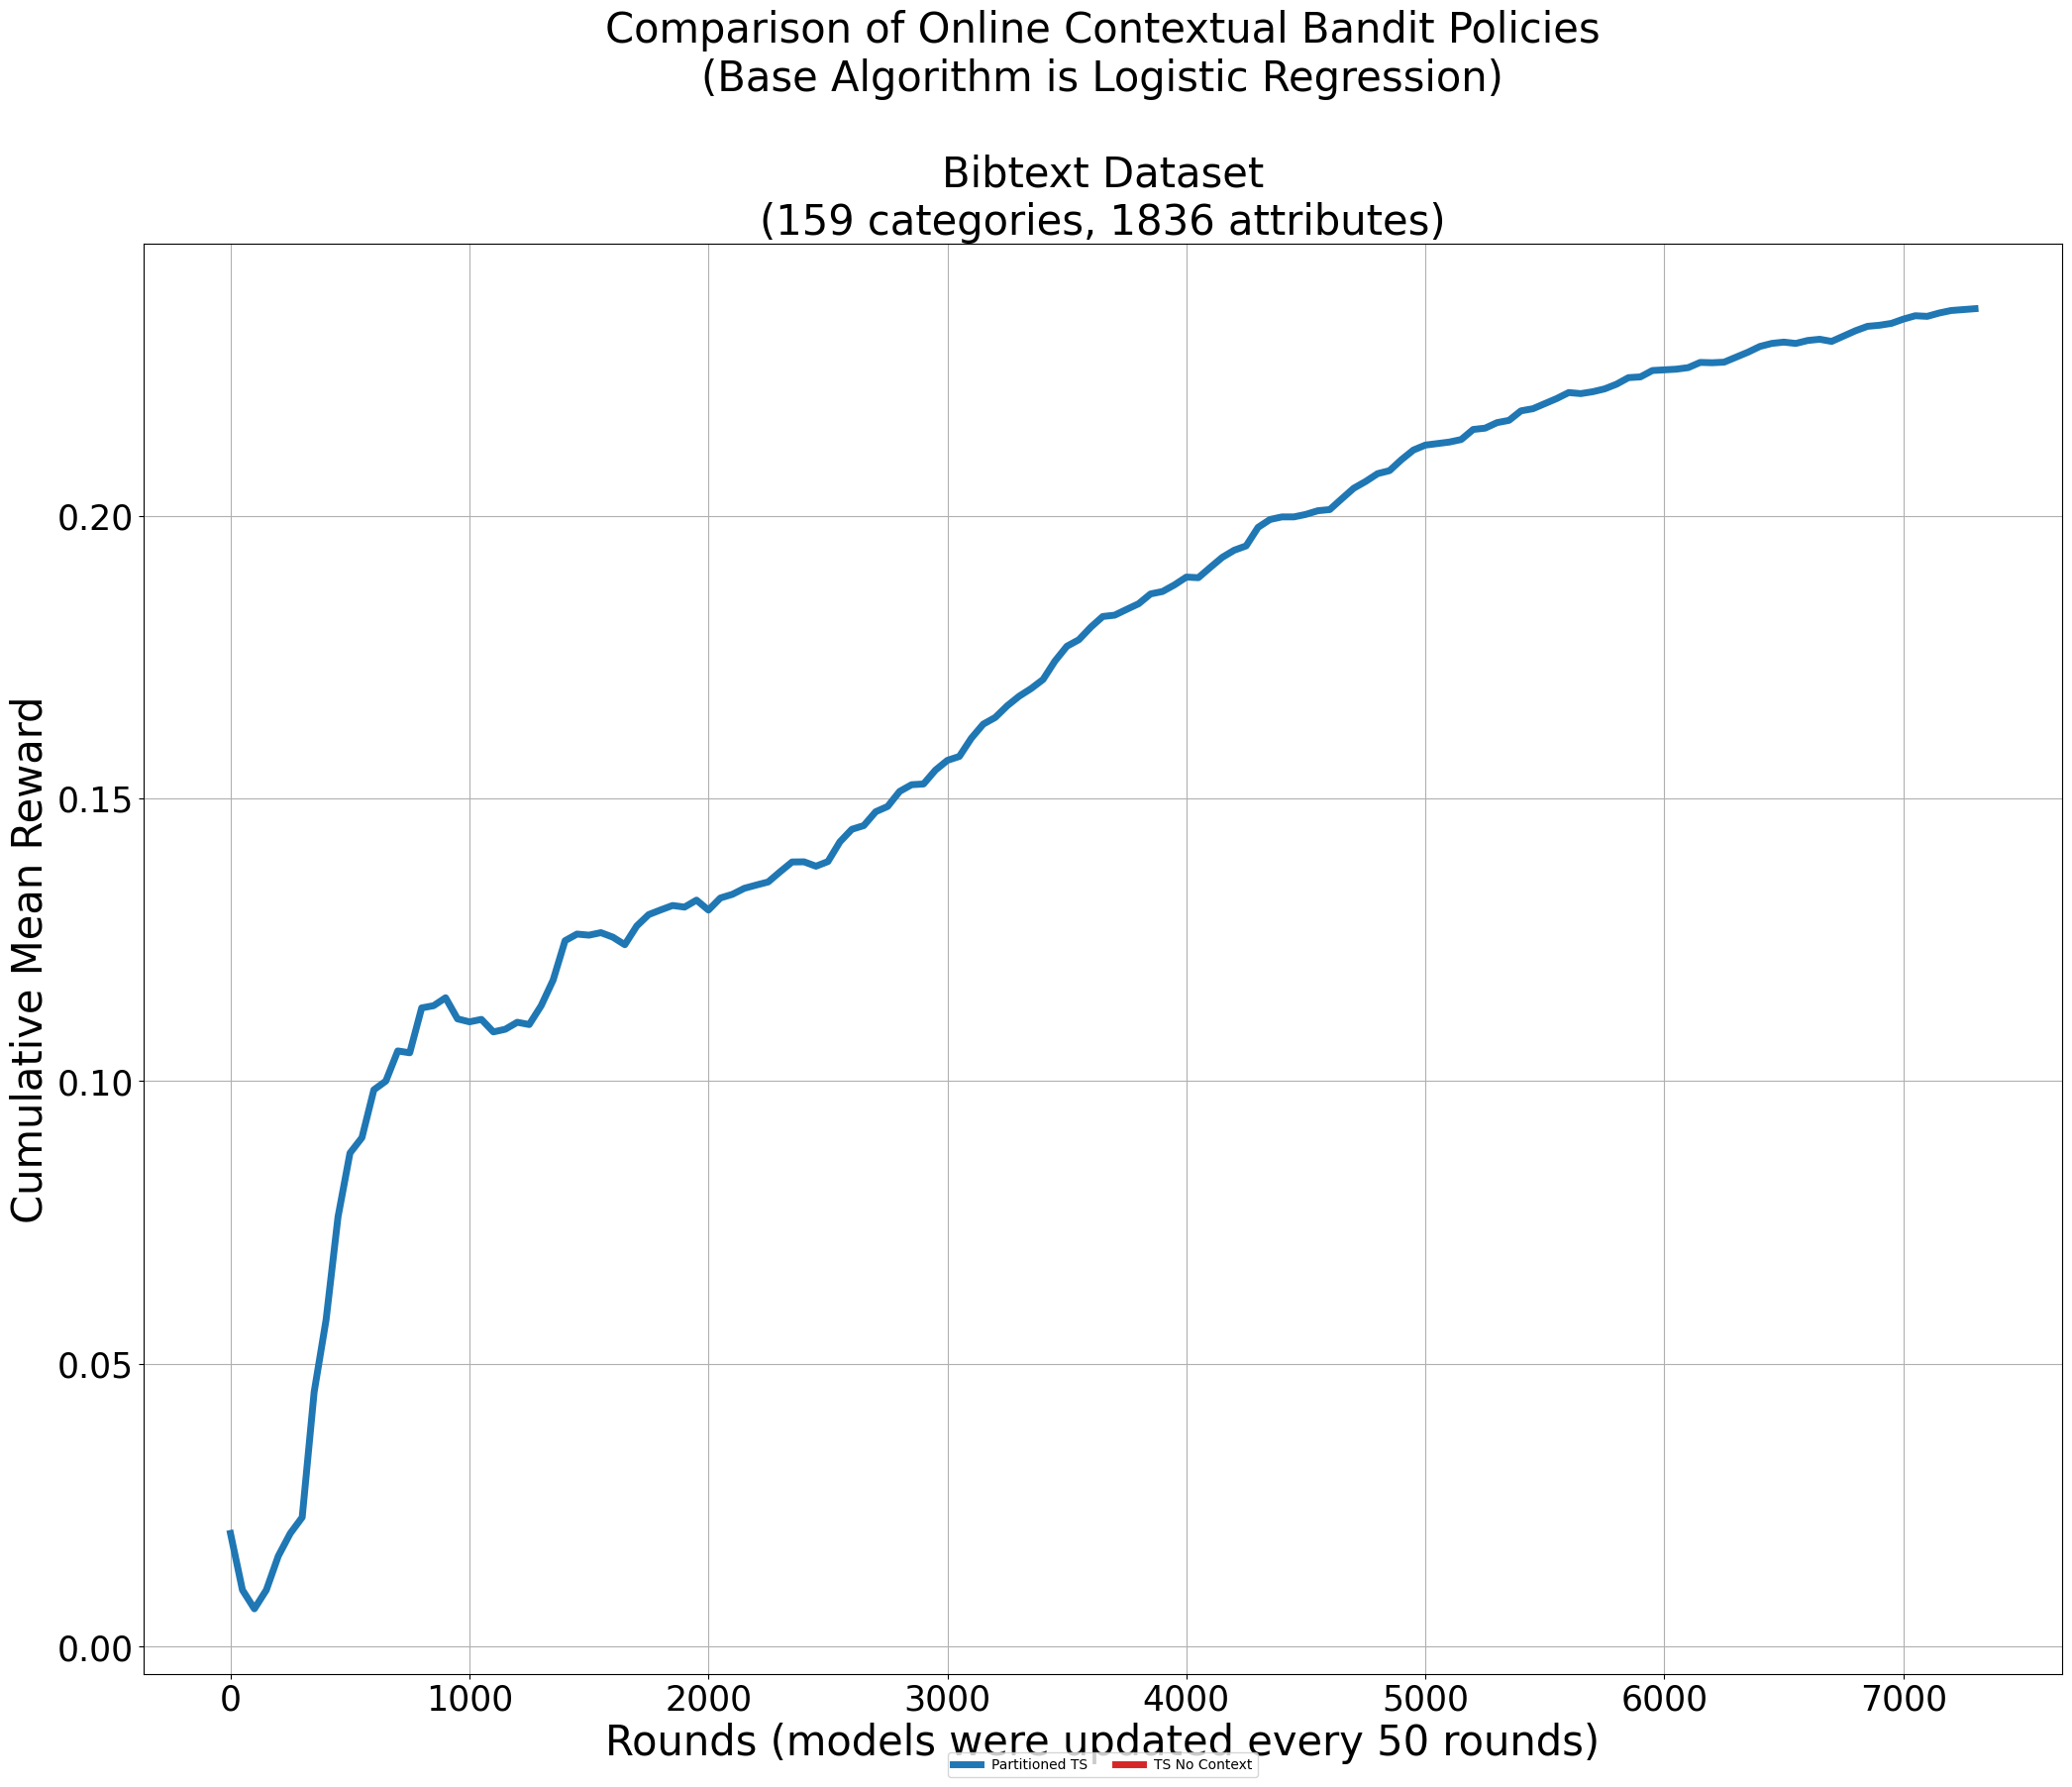

In [32]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from contextualbandits.online import PartitionedTS, ExploreFirst, _BasePolicy, _BasePolicyWithExploit, BootstrappedTS
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import _BasePolicy
import matplotlib.pyplot as plt
from pylab import rcParams 

X, y = parse_data("Bibtex_data.txt")
print(X.shape)
print(y.shape)
nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
contexts = X # these are the features
rewards = y # these are the labels
n_arms = nchoices

partitioned_ts_agent = PartitionedTS(
    nchoices=nchoices,  # Explicitly pass nchoices here
    beta_prior=beta_prior_ts,  # Custom beta prior for Thompson Sampling
    random_state=2222,  # Set a random state for reproducibility
    njobs=-1,  # Use all CPU cores for parallel processing
    max_depth=5,  # Optional: You can pass additional decision tree parameters here
    min_samples_leaf=6  # Optional: Minimum samples per leaf
)

ts_nocontext_agent = ThompsonSamplingNoContext(nchoices=nchoices)

models = [partitioned_ts_agent, ts_nocontext_agent]

rewards_part_ts, rewards_ts_nocontext = [[] for _ in range(len(models))]
lst_rewards = [rewards_part_ts, rewards_ts_nocontext]

# batch size - algorithms will be refit after N rounds
batch_size = 50
# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# Initial Parameters Debugging
print("Initial Parameters:")
print(f"nchoices: {nchoices}, beta_prior: {beta_prior_ts}")

# Initial model fitting
for model in models:
    if isinstance(model, ThompsonSamplingNoContext):
        model.fit(None, action_chosen, rewards_received)
    else:
        model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
print("Initial Model Fitting Done.")
print(f"Actions chosen: {action_chosen}")
print(f"Rewards received: {rewards_received}")

# these lists will keep track of which actions does each policy choose
lst_a_partTS, lst_a_tsnocon = [action_chosen.copy() for i in range(len(models))]
lst_actions = [lst_a_partTS, lst_a_tsnocon]

print(f"Initial rewards: {rewards_received.sum()}")

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    # Choosing actions for this batch
    if isinstance(model, ThompsonSamplingNoContext):
        actions_this_batch = np.array([model.pick_action() for _ in range(batch_end - batch_st)])
    else:
        actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # Debugging: Print predictions and actual rewards
    print(f"Batch {batch_st}-{batch_end}: Actions Predicted: {actions_this_batch}")
    print(f"Corresponding Contexts: {X_global[batch_st:batch_end, :]}")
    print(f"Actual Rewards: {y_global[np.arange(batch_st, batch_end), actions_this_batch]}")

    # Keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # Adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # Refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    if isinstance(model, ThompsonSamplingNoContext):
        for action, reward in zip(actions_this_batch, y_global[np.arange(batch_st, batch_end), actions_this_batch]):
            model.update(action, reward)
    else:
        model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])
    
    return new_actions_hist

# Running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])

    # Update model and print tree structure if available
    print(f"Model Updated after Batch {batch_end}")

    if hasattr(partitioned_ts_agent, 'trees_'):
        for idx, tree in enumerate(partitioned_ts_agent.trees_):
            print(f"Tree {idx}: Number of nodes: {tree.tree_.node_count}, Max depth: {tree.tree_.max_depth}")
    
    if hasattr(partitioned_ts_agent, '_oracles') and hasattr(partitioned_ts_agent._oracles, 'tree'):
        for j, tree in enumerate(partitioned_ts_agent._oracles.tree):
            print(f"Tree {j}: Number of nodes: {tree.tree_.node_count}")
            print(f"Tree {j}: Max Depth: {tree.tree_.max_depth}")
            print(f"Tree {j}: Min Samples Leaf: {tree.min_samples_leaf}")
    
    lst_a_partTS = simulate_rounds(partitioned_ts_agent,
                                   rewards_part_ts,
                                   lst_a_partTS,
                                   X, y,
                                   batch_st, batch_end)
    
    print(f"Cumulative reward after batch {i}: {sum(rewards_part_ts)}")

    # Action Distribution
def get_action_distribution(actions_hist, nchoices):
    return {i: np.sum(actions_hist == i) for i in range(nchoices)}

print(f"Action Distribution After Batch {batch_end}: {get_action_distribution(lst_a_partTS, nchoices)}")


def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew = list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1) * batch_size))
    return mean_rew

# Plotting results
rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors = plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_part_ts), label="Partitioned TS", linewidth=lwd, color=colors[0])
plt.plot(get_mean_reward(rewards_ts_nocontext), label="TS No Context", linewidth=lwd, color=colors[6])


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i * 20 for i in range(8)], [i * 1000 for i in range(8)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)', size=30)
plt.grid()
plt.show()
